# Obesity, Exercise and Nutrition in the USA

## Table of Contents
1. [Summary](##summary)
2. [Requirements and Configuration](##requirements-and-configuration)
3. [ELT Process](##elt-process)
   - 3.1. [Connect to the DB and check it](###connect-to-the-db-and-check-it)
   - 3.2. [Extract](###extract)
   - 3.3  [Load](###load)
4. [Transform](##transform)
   - 4.1. [Missing Values](###missing-values)
   - 4.2. [Removing Unnecessary or Duplicate Fields](####removing-unnecessary-or-duplicate-fields)
       - 4.2.1.  ["year_start" and "year_end"](####"year_start"-and-"year_end")
       - 4.2.2 ["percent" and "percent_alt"](####"percent"-and-"percent_alt")
       - 4.2.3. ["class_data_1" and "class_data_2"](####"class_data_1"-and-"class_data_2")
       - 4.2.4. [Remove Fields which are Always Empty or Never Change"](####remove-fields-which-are-always-empty-or-never-change)
   - 4.3. [Embed the Data Related to the Population](###embed-the-data-related-to-the-population)
   - 4.4. [Check for Duplicate Entries](###check-for-duplicate-entries)
   
5. [Data Structure](##data-structure)
6. [Dataflow](##dataflow)
7. [Data Analysis](##data-analysis)
    - 7.1. [Which State Has the Highest Percentage of Adults who are either Obese or Overweight?](###which-state-has-the-highest-percentage-of-adults-who-are-either-obese-or-overweight?)
    - 7.2. [Are Certain Ethnicites More Likely to be Obese or Overweight?](####are-certain-ethnicities-more-likely-to-be-obese-or-overweight?)
    - 7.3. [Is a Lower Income Associated with Higher Rates of Adults being Overweight or Obese?](####is-a-lower-income-associated-with-higher-rates-of-adults-beaing-overweight-or-obese?)
    - 7.4. [Has There Been a Decline or Increase in Obesity from 2011 to 2023?](####has-there-been-a-decline-or-increase-in-obesity-from-2011-to-2023?)
    - 7.5. [Which State Has the Lowest Percentage of Adults Consuming Vegetables or Fruits at Least Once per Day?](####which-state-has-the-lowest-percentage-of-adults-consuming-vegetables-or-fruits-at-least-once-per-day?)
    - 7.6. [What Percentage of Americans Regularily Exercise?](####what-percentage-of-americans-regularily-exercise?)
8. [Conclusions](##conclusions)
9. [Learnings](##learnings)
10. [Disclaimer](##disclaimer)

## 1. Summary

Obesity is often referred to as a global epidemic whose prevalence grows in develped and developing countries alike. One of the countries where it is most prevalent is undoubtedly the United States of America. Since 1984, The Behavioral Risk Factor Surveillance System (BRFSS) has conducted health-related telephone surveys on behalf the Center of Disease Control and Prevention to collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. Every year, it conducts suverys with over 400'000 adults across the US. 

On the basis of their surveys, they have published a dataset found in the "Data Catalog" of Data.gov which includes data on adults' diet, physical activity, and weight status which spans from 2011 to 2023 and make be found at the following link: https://catalog.data.gov/dataset/nutrition-physical-activity-and-obesity-behavioral-risk-factor-surveillance-system. 

Using this data, we will closely examine the percentage of individuals qualified as obese or overweight in each US State, examine how these percentages changed over time and also possible correlated factors, such as income, ethnicity, nutrition and exercise. 

To do so, we will first extract the data, load it into MongoDB then transform it. The transformation phase includes some quality checks such as identifying missing values, duplicates between fields and duplicates within the data and also identifying perpetually empty or unchanging fields which bring nothing to the analysis. 

We will then move on to the analysis, by examining the following main questions which will be broken down into smaller sub-questions:
- Which State has the highest percentage of adults who are either obese or overweight?
- Are certain ethnicites more likely to be obese or overweight?
- Is a lower income associated with higher rates of adults being overweight or obese?
- Has there been a decline or increase in obesity from 2011 to 2023?
- Which State has the lowest percentage of adults consuming vegetables or fruits at least once per day?
- What percentage of Americans regularily exercise?



## 2. Requirements and Configuration

In [27]:
#import required packages
import requests
import pymongo
from pprint import pprint
import pandas as pd
import json
import datetime
import copy
import numpy as np 
import matplotlib.pyplot as plt 
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [28]:
#Set options for pandas dataframes
pd.set_option('max_colwidth', 400)

## 3. ELT Process

### 3.1. Connect to the DB and check it

In [ ]:
CNX_STR = "mongodb+srv://..."
client = pymongo.MongoClient(CNX_STR)

In [39]:
db = client['db_obesity_usa']

In [40]:
db.list_collection_names()

['USA']

In [41]:
col = db.USA

In [42]:
col.count_documents({})

0

### 3.2. Extract

In [43]:
url = 'https://data.cdc.gov/api/views/hn4x-zwk7/rows.json?accessType=DOWNLOAD'
r = requests.get(url)
data = r.json()

The extract returned metadata as well as operative data, but we are interested in the operative data only such as in the below example:

In [51]:
#example of data we want to extract
print(data['data'][0][:500]) 

['row-yqys~w27i.drzu', '00000000-0000-0000-2A49-2BDB84F72308', 0, 1728324395, None, 1728324395, None, '{ }', '2011', '2011', 'AK', 'Alaska', 'BRFSS', 'Obesity / Weight Status', 'Obesity / Weight Status', 'Percent of adults aged 18 years and older who have obesity', '2011', 'Value', '23.3', '23.3', None, None, '16.1', '32.4', '128', None, None, None, None, None, '2 or more races', ['{"address": "", "city": "", "state": "", "zip": ""}', '64.845079957001', '-147.722059036', None, False], 'OWS', 'OWS1', 'Q036', 'VALUE', '02', 'Race/Ethnicity', '2 or more races', 'RACE', 'RACE2PLUS']


In [52]:
#We have over 100'000 questions in our data
len(data['data'])

104272

### 3.3. Load

Since the data is composed of arrays instead of dictionaries with key-value pairs, loading it as is into the database returns an error. We must first make sure that it is in the proper format by defining keys to the values we extracted.

In [53]:
key_names = ['row_name', 'row_code', 'row_number', 'timestamp_1', 'null_field1',
             'timestamp_2','null_field2', 'json_field', 'year_start',
             'year_end','state_abbr', 'state',
             'data_Source', 'class_data_1', 'class_data_2', 
             'question', 'year', 'type', 'percent', 
             'percent_alt','data_value_footnote_symbol',
             'footnote', 'low_confidence_limit', 'high_confidence_limit', 'sample_size', 
             'total', 'age', 'education','gender', 'income', 'ethnicity',
             'geo_location', 'class_ID', 'topic_ID', 'question_ID', 'data_value_type', 
             'location_ID','stratification_category',
             'stratification','stratification_category_ID_1', 
             'stratification_category_ID_2']

In [54]:
documents = [dict(zip(key_names, item)) for item in data['data']]

In [55]:
#checking the result
documents[0]

{'row_name': 'row-yqys~w27i.drzu',
 'row_code': '00000000-0000-0000-2A49-2BDB84F72308',
 'row_number': 0,
 'timestamp_1': 1728324395,
 'null_field1': None,
 'timestamp_2': 1728324395,
 'null_field2': None,
 'json_field': '{ }',
 'year_start': '2011',
 'year_end': '2011',
 'state_abbr': 'AK',
 'state': 'Alaska',
 'data_Source': 'BRFSS',
 'class_data_1': 'Obesity / Weight Status',
 'class_data_2': 'Obesity / Weight Status',
 'question': 'Percent of adults aged 18 years and older who have obesity',
 'year': '2011',
 'type': 'Value',
 'percent': '23.3',
 'percent_alt': '23.3',
 'data_value_footnote_symbol': None,
 'footnote': None,
 'low_confidence_limit': '16.1',
 'high_confidence_limit': '32.4',
 'sample_size': '128',
 'total': None,
 'age': None,
 'education': None,
 'gender': None,
 'income': None,
 'ethnicity': '2 or more races',
 'geo_location': ['{"address": "", "city": "", "state": "", "zip": ""}',
  '64.845079957001',
  '-147.722059036',
  None,
  False],
 'class_ID': 'OWS',
 'top

Now we load the data into MongoDB:

In [56]:
for doc in documents:
    col.insert_one(doc)

In [57]:
#All the docs have been loaded
col.count_documents({})

104272

## 4. Transform

In [ ]:
#Connect to the DB
CNX_STR = "mongodb+srv://..."
client = pymongo.MongoClient(CNX_STR)
db = client['db_obesity_usa'].USA

### 4.1. Missing Values

For some questions, data is not available because sample size is insufficient. In that case, a footnote is present:

In [59]:
db.distinct("footnote")

[None, 'Data not available because sample size is insufficient.']

In [60]:
#check the number of documents with no data
r = db.aggregate([
    {"$group":{"_id": "$footnote", "count":{"$sum":1}}}
     ])
pd.DataFrame(r)

,_id,count
0,None,93505
1,Data not available because sample size is insufficient.,10767


In [61]:
# These documents with a footnote can be removed from the database

result = db.delete_many({"footnote": 
                         "Data not available because sample size is insufficient."})
print(f"Deleted {result.deleted_count} documents with the specified footnote.")

Deleted 10767 documents with the specified footnote.


In [62]:
# let's check if there are some missing values found in "percent",
# "percent_alt" or "sample_size"

matches = list(db.find({"$or": [{"percent": None}, {"percent_alt": None},
                                {"sample_size":None}]}))

if matches:
    for m in matches:
        pprint(m)
else:
    print("No entries found with 'None'")

No entries found with 'None'


Therefore, we consider that there are no missing values for answers to the questions.

### 4.2. Removing Unnecessary or Duplicate Fields

#### 4.2.1. "year_start" and "year_end"

We want to check if year_start and year_end are ever different. If it is the case, then we keep both fields. Otherwise, we keep just one field for the year. 

In [63]:
year_non_matches = db.aggregate([
    
    #making sure that year_start and year_end are integers
    {"$addFields": {
        "year_start": {"$toInt":"$year_start"}, 
        "year_end":{"$toInt":"$year_end"}}}, 
    
    #match on the non-matching entries
    {"$match":{
        "$expr": {"$ne": ["$year_start", "$year_end"]}}
    },
    
    #project the needed fields
    {"$project": {"year_start": 1, "year_end": 1}}
     ])

for m in year_non_matches:
        pprint(m)
else:
    print("Non-matching entries were not found")

Non-matching entries were not found


In [64]:
#the "year" field has some missing values
db.distinct("year")

[None,
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021']

Since year_start and year_end are always the same and year has some missing values, we only keep "year_start" as the "year":

In [65]:
# remove year_start and year_end:

result_unset = db.update_many(
    {},
    {"$unset": {"year":"", "year_end":""}})

print(f"Unset 'year' and 'year_end' fields in {result_unset.modified_count} documents.")



#rename year_start as year:

result_rename = db.update_many(
    {},
    {"$rename": {"year_start":"year"}})

print(f"Renamed 'year_start' to 'year' in {result_rename.modified_count} documents.")

Unset 'year' and 'year_end' fields in 93505 documents.
Renamed 'year_start' to 'year' in 93505 documents.


#### 4.2.2. "percent" and "percent_alt"

We do the same for "percent" and "percent_alt":

In [66]:
# check if there are non-matching "percent" and "percent_alt" 
# entries for the same question

percent_non_matches = db.aggregate([
    
    #making sure that year_start and year_end are integers
    {"$addFields": {
        "percent": {"$toDouble":"$percent"}, 
        "percent_alt":{"$toDouble":"$percent"}}},
    
    #matching the necessary fields
    {"$match":{
        "$expr": {"$ne": ["$percent", "$percent_alt"]}}
    },
    
    #project stage
    {"$project": {"percent": 1, "percent_alt": 1}}
     ])

for m in percent_non_matches:
        pprint(m)
else:
    print("Non-matching entries were not found")

Non-matching entries were not found


In [67]:
# remove "percent_alt" since it is always identical to "percent":

result_update =db.update_many(
    {},
    {"$unset": {"percent_alt":""}})

print(f"Unset 'percent_alt' field in {result_update.modified_count} documents.")

Unset 'percent_alt' field in 93505 documents.


#### 4.2.3. "class_data_1" and "class_data_2"

In [68]:
# Are there non-matching "class_data_1" and "class_data_2" entries per question?:

r = db.aggregate([
    {"$match":{
        "$expr": {"$ne": ["$class_data_1", "$class_data_2"]}}
    },
    {"$project": {"class_data_1": 1, "class_data_2": 1}}
     ])

amount_entries = len(pd.DataFrame(r))
print(f"There are {amount_entries} non-matching fields")

There are 58117 non-matching fields


Here we want to examine a bit closer what "class_data_1" and "class_data_2" consist of to be able to decide if duplicates should be removed or not:

In [69]:
db.distinct("class_data_1")

['Fruits and Vegetables', 'Obesity / Weight Status', 'Physical Activity']

In [70]:
db.distinct("class_data_2")

['Fruits and Vegetables - Behavior',
 'Obesity / Weight Status',
 'Physical Activity - Behavior']

"class_data_1" indicates the theme of the question and "class_data_2" seems to indicate the specific topic of the question. A minority are identical. We therefore keep both fields and rename them accordingly:

In [71]:
# Rename "class_data_1" and "class_data_2":

rename_class = db.update_many(
    {},
    {"$rename": {"class_data_1":"theme_of_question", "class_data_2":"topic_of_question"}})

print(f"Renamed fields in {rename_class.modified_count} documents.")

Renamed fields in 93505 documents.


#### 4.2.4. Remove Fields which are Always Empty or Never Change

Here we can see that there are some fields which are always empty or have constant values. We need to remove them.

In [72]:
# the below fields are always empty or the same:

fields_to_check = ["row_number", "timestamp_1", "timestamp_2",
                   "data_Source", 
                   "data_value_footnote_symbol",
                   "footnote","data_value_type",
                   "null_field1", "null_field2", "json_field", "type"]

for field in fields_to_check:
    check = db.distinct(field)
    print(f"these are the unique values of {field}:{check}")

these are the unique values of row_number:[0]
these are the unique values of timestamp_1:[1728324395]
these are the unique values of timestamp_2:[1728324395]
these are the unique values of data_Source:['BRFSS']
these are the unique values of data_value_footnote_symbol:[None]
these are the unique values of footnote:[None]
these are the unique values of data_value_type:['VALUE']
these are the unique values of null_field1:[None]
these are the unique values of null_field2:[None]
these are the unique values of json_field:['{ }']
these are the unique values of type:['Value']


In [73]:
# We remove the above fields from the collection:

remove_fields = db.update_many(
    {},
    {"$unset": {"row_number":"", "timestamp_1":"", "timestamp_2":"",
                "data_Source":"","data_value_footnote_symbol":"", 
                "footnote":"","data_value_type":"",  "null_field1":"",  
                "null_field2":"","json_field":"", "type":""}})

print(f"Removed fields in {remove_fields.modified_count} documents.")

Removed fields in 93505 documents.


### 4.3. Embed the Data Related to the Population

There are multiple advantages to using a de-normalized model instead of a normalized one in this instance:

1) We have a database which should not be updated regularly. The only updates would be additional data points for future years.

2) Since all related data is in a single document, we will have atomic operations.

3) Common operations will require fewer queries and updates.

4) For each state, we have many questions and many starta of various populations being considered. The answers are in turn viewed in the context of the questions.

5) We will be frequently retrieving data related to the population for our analyses

In [74]:
# We embed data related to the population:

embed_data = db.update_many(
    {},
    [
        {"$set":{
            "population_information":{
                "age":"$age",
                "education":"$education",
                "income":"$income",
                "ethnicity":"$ethnicity",
                "gender":"$gender",
                "sample_size":"$sample_size",
                "total":"$total",
                "stratification_category":"$stratification_category",
                "stratification":"$stratification",
                "stratification_category_ID_1":"$stratification_category_ID_1",
                "stratification_category_ID_2":"$stratification_category_ID_2"
            }}}, 
        {"$unset": ["age", "education", "income", "ethnicity", "gender", "sample_size",
                    "total", "stratification_category", 
                    "stratification",
                    "stratification_category_ID_1", "stratification_category_ID_2"]}
    ])

print(f"We embedded data in {embed_data.modified_count} documents.")

We embedded data in 93505 documents.


### 4.4. Check for Duplicate Entries

There are duplicate questions in the document for the same years and States. However, after further investigation, we realize that these questions always have differences in the population characteristics (e.g. a particular ethnicity or age group). Therefore, we choose to keep all documents currently in the collection.

Here we can see that there are some duplicate questions and percentages per State and per year:

In [76]:
# Identify duplicate questions per State and Year with the same answers :

r = db.aggregate([
    
    # group by year, State, question and percent and count occurences:
    {"$group": {
        "_id":{"a":"$year", "b":"$state", "c":"$question","d":"$percent"},
        "count":{"$sum":1}}},
    
    # keep only questions which have one or more duplicates
    {"$match": {"count": {"$gt":1}}},
    
    #organize the output
    {"$project": {"_id":0, "Question": "$_id", "count":"$count"}},
])
pd.DataFrame(r)

,Question,count
0,"{'a': '2019', 'b': 'Montana', 'c': 'Percent of adults who engage in no leisure-time physical activity', 'd': '21.1'}",2
1,"{'a': '2017', 'b': 'North Dakota', 'c': 'Percent of adults who report consuming fruit less than one time daily', 'd': '37.4'}",2
2,"{'a': '2011', 'b': 'Arkansas', 'c': 'Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)', 'd': '26.9'}",2
3,"{'a': '2023', 'b': 'Illinois', 'c': 'Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)', 'd': '43.2'}",2
4,"{'a': '2015', 'b': 'Tennessee', 'c': 'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)', 'd': '46.3'}",2
...,...,...
5607,"{'a': '2015', 'b': 'Puerto Rico', 'c': 'Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)', 'd': '17.2'}",2
5608,"{'a': '2012', 'b': 'Minnesota', 'c': 'Percent of adults aged 18 years and older who have an overweight classification', 'd': '33.5'}",2
5609,"{'a': '2019', 'b': 'Puerto Rico', 'c': 'Percent of adults aged 18 years and older who have obesity', 'd': '35.5'}",2
5610,"{'a': '2019', 'b': 'Alabama', 'c': 'Percent of adults who report consuming fruit less than one time daily', 'd': '47.3'}",2


However, in this next aggregation we can see that there are in fact no duplicate entries since adding "population_information" to "$group" yields no matches, meaning that different strata of the population are considered for each question:

In [77]:
duplicates = db.aggregate([
    
    # group by year, State, question, percent and popluation_information
    # and count occurences:
    {"$group": {
        "_id":{"year": "$year", "State":"$state","question":"$question", 
               "percent": "$percent",
               "population_information":"$population_information"},
        "count":{"$sum":1}}},
    
    #return only questions with one or more duplicates
    {"$match": {"count": {"$gt":1}}}
])

for d in duplicates:
        pprint(d)
else:
    print("Duplicates were not found")

Duplicates were not found


## 5. Data Structure 

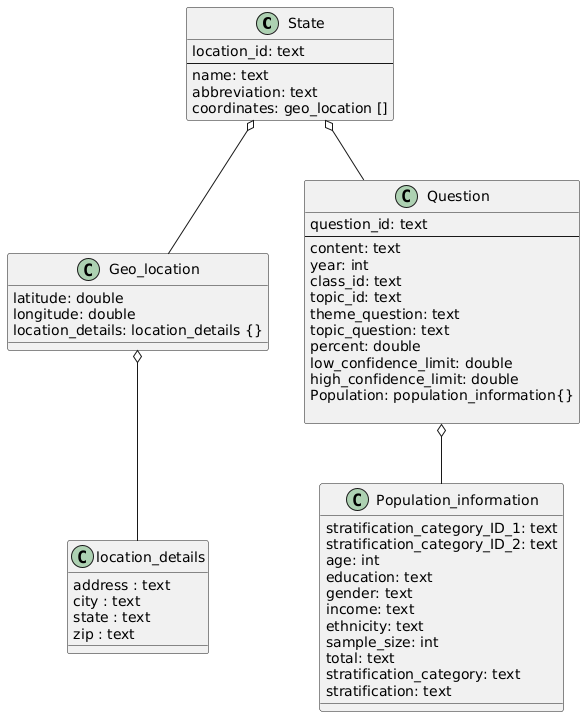

In this class diagram, we can see that each State is associated to many questions. Likewise, questions are associated to many States. Each question's answer is a percentage with a high and low confidence limit. Population_information is embedded data that is associated to each question. Geo_location is located in an array and is associated to each State. It also has embedded data which concern location details such as address, city, State and zip. 

## 6. Dataflow

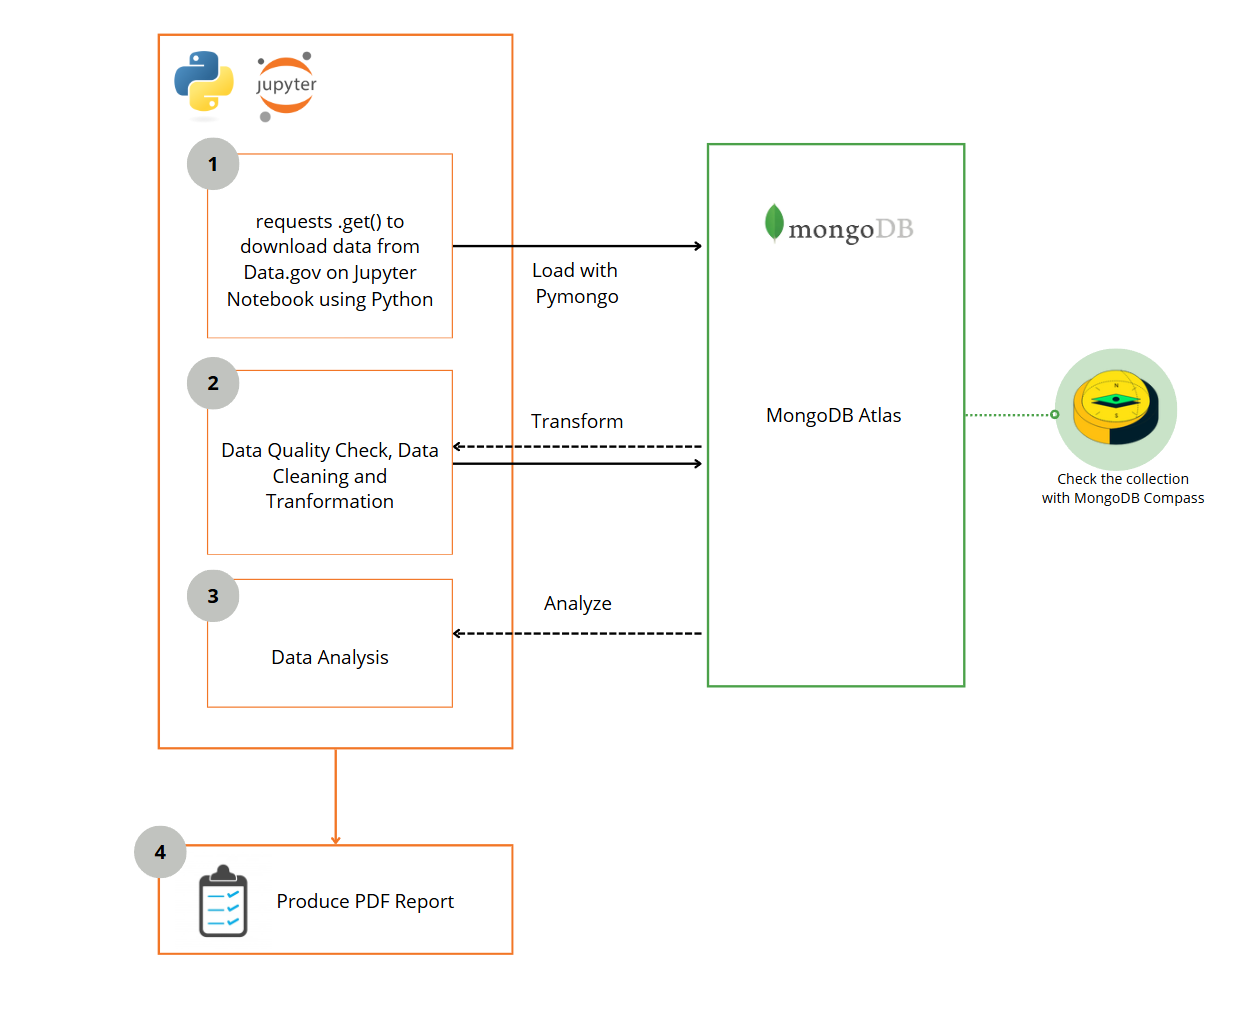

The above shows how we proceed and the resulting dataflow. The data is first downloaded from the Data.gov url, then loaded in MongoDB Atlas. Then it is cleaned and transformed in the jupyter notebook with pymongo before being updated in the database. We will then use the data in MongoDB Atlas to make our analysis before finally producing the PDF report output.

## 7. Data Analysis

### 7.1. Which State Has the Highest Percentage of Adults who are either Obese or Overweight?

First, let us consider the percentage of adults who are obese. 

We select the documents with a field indicating "total" answering the question : "Percent of adults 18 years and older who have obesity". "Total" indicates that we are looking at the percentage for the overall sample size of the survey, without taking into account specific characteristics of the population. We use the percentage indicated in each year per State and make an average over 12 years. 

In [493]:
# Top 5 US States with the Highest Average Percentage of Obesity from 2011 to 2023

r = db.aggregate([
    
    # Here we make sure that "percent" is a double
    {"$addFields": {"percent": {"$toDouble":"$percent"}}},

    # We select the fields we are interested in
    {"$project":{"_id":0, "state":1, "year":1, "question":1, "percent":1,
                 "population_information":1}},

    # We select the specific question related to obesity of adults
    # which concerns the total population sample
    {"$match":{"question":"Percent of adults aged 18 years and older who have obesity",
               "population_information.total":"Total"}}, 

    # Calculate the average per State
    {"$group":{"_id":"$state", "Average": {"$avg":"$percent"}}},
    
    #Project the results
    {"$project": {"_id":0, "State": "$_id",
    "Average": "$Average"}},

    # Order the averages from the highest to the lowest
    {"$sort":{"Average":-1}},

    #Return the top 5 US States
    {"$limit":5}
])
pd.DataFrame(r)

,State,Average
0,West Virginia,37.653846
1,Mississippi,37.615385
2,Louisiana,36.415385
3,Arkansas,36.007692
4,Alabama,35.938462


West Virginia is the US State with the highest average percentage of obesity over the period from 2011 to 2023 at 37.65%, followed by Mississippi, Louisiana, Arkansas and Alabama. The percentages of obese people in the USA can be visualized on the following map, where we can see that the South-Eastern part of the United States has the most obese people overall:

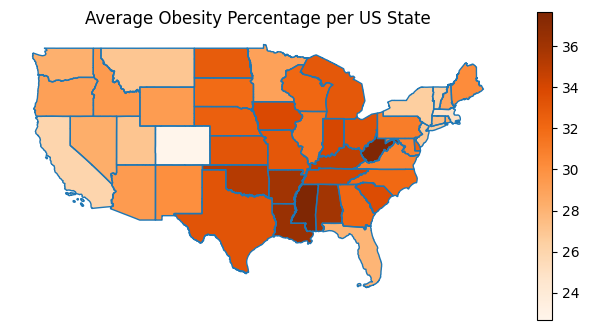

In [79]:
#US States' Average Percentage of Obesity

r = db.aggregate([
    
    # Here we make sure that "percent" is a double
    {"$addFields": {"percent": {"$toDouble":"$percent"}}},

    # We select the fields we are interested in
    {"$project":{"_id":0, "state":1, "year":1, "question":1, "percent":1,
                 "population_information":1, "geo_location":1}},

    # We select the specific question related to obesity of adults 
    #which concerns the total population sample
    {"$match":{"question":"Percent of adults aged 18 years and older who have obesity",
               "population_information.total":"Total"}}, 

    # Calculate the average per State
    {"$group":{"_id":"$state", "Average": {"$avg":"$percent"}}},
    
    #Project the results
    {"$project": {"_id":0, "State": "$_id",
    "Average": "$Average"}}
])
table = pd.DataFrame(r)

# We include State coordinates in our data frame 
path = r"D:\HSLU - Master's in Information and Data Science\Automne 2024\
NoSQL_with_python_MongoDB\tl_2023_us_state\tl_2023_us_state.shp"
df = gpd.read_file(path)
df = df.merge(table, how="left", left_on="NAME", right_on="State")

# We exclude oversea territories to obtain a clean visualization
non_continental = ['VI','MP','HI','GU','AK','AS','PR']
for n in non_continental:
    df = df[df.STUSPS != n]

#We display the map 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
df.boundary.plot(ax=ax, linewidth=1)
df.plot(column="Average", cmap="Oranges", legend=True, ax=ax, 
                legend_kwds={"orientation": "vertical"})

# Add title and remove axis
ax.set_title("Average Obesity Percentage per US State")
ax.axis("off")

# Display the map
plt.show()

Furthermore, the highest percentage of people who are either overweight or obese is also found in the State of West Virginia with an average of 71.2% of people either overweight or obese:

In [368]:
#Top 5 US States with the Highest Average Percentage of Obese or
# Overweight People from 2011 to 2023

r = db.aggregate([
    
    # Here we make sure that "percent" is a double:
    {"$addFields": {"percent": {"$toDouble": "$percent"}}},  
    
    # We $match only for the questions we are interested in for the total sample
    #for each US State survey
    {"$match": {"population_information.total": "Total", 
                "question": {"$in": [
                "Percent of adults aged 18 years and older who have obesity",
                """Percent of adults aged 18 years and older who have an overweight
                classification"""]}}},
    
    #Here we calculate the average for each question per US State
    {"$group": {"_id": {"state": "$state", "question": "$question"},
        "average_percent": {"$avg": "$percent"}}},
    
    # Then we use conditional logic to get the average percentage 
    #of obese and overweight individuals
    {"$group": {
        "_id": "$_id.state",
        "obesity_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq": ["$_id.question",
                                   """Percent of adults aged 18 years
                                   and older who have obesity"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}},
        "overweight_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq": ["$_id.question",
                                   """Percent of adults aged 18 years and older who
                                   have an overweight classification"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}}}},
    
    # Add both averages to get the overall amount of overweight
    #or obese people in each US State
    {"$project": {"_id":0, "US State": "$_id",
        "Average Percentage": {"$add": ["$obesity_avg", "$overweight_avg"]}}},
    
    # Sort the averages by descending order
    {"$sort": {"Average Percentage": -1}},

    #Return the top 5 States
    {"$limit": 5}])

pd.DataFrame(r)


,US State,Average Percentage
0,West Virginia,71.215385
1,Mississippi,71.115385
2,Louisiana,69.815385
3,Alabama,69.707692
4,Arkansas,69.507692


In fact, 54 US States and overseas territories in the dataset have had on average more than half of their population as either overweight or obese from 2011 to 2023:

In [370]:
# US States with more than half of their population as overweight or obese: 

r = db.aggregate([
    
    # Here we make sure that "percent" is a double:
    {"$addFields": {"percent": {"$toDouble": "$percent"}}},  
    
    # We $match only for the questions we are interested in for the total sample
    # for each US State total sample
    {"$match": {"population_information.total": "Total", 
                "question": {"$in": [
                "Percent of adults aged 18 years and older who have obesity",
                """Percent of adults aged 18 years and older who have an
                overweight classification"""]}}},
    
    #Here we calculate the average for each question per US State
    {"$group": {"_id": {"state": "$state", "question": "$question"},
        "average_percent": {"$avg": "$percent"}}},
    
    # Then we use conditional logic to get the average percentage of obese
    # and overweight individuals
    {"$group": {
        "_id": "$_id.state",
        "obesity_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq": ["$_id.question", 
                                   """Percent of adults aged 18 years
                                   and older who have obesity"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}},
        "overweight_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq": ["$_id.question", 
                                   """Percent of adults aged 18 years and
                                   older who have an overweight classification"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}}}},
    
    # Add both averages to get the overall amount of overweight or obese
    # people in each US State
    {"$project": {"state": "$_id",
        "combined_average": {"$add": ["$obesity_avg", "$overweight_avg"]}}},
    
    # Match only States with more than 50% of the population as overweight
    # or obese and count them. Exclude the National percentage.  
    {"$match": {"combined_average" :{"$gt": 50.0}, "state":{"$ne":"National"}}},
    {"$count": "Amount"},
                
    # Sort the averages by descending order
    {"$sort": {"combined_average": -1}}

])

for i in r:
    print(f"""There are {i["Amount"]} States or territories with over 50% of adults
    overweight or obese on average""")

There are 54 States or territories with over 50% of adults overweight or obese on average


###  7.2. Are Certain Ethnicites More Likely to be Obese or Overweight? 

We have 8 different ethnicities in the dataset:

In [372]:
# Ethnicities in the dataset

db.distinct("population_information.stratification",
            {"population_information.stratification_category":
             "Race/Ethnicity"})

['2 or more races',
 'American Indian/Alaska Native',
 'Asian',
 'Hawaiian/Pacific Islander',
 'Hispanic',
 'Non-Hispanic Black',
 'Non-Hispanic White',
 'Other']

In [381]:
# Percentage of individuals qualified as obese or overweight by ethnicity

r = db.aggregate([
    
    # Here we make sure that "percent" is a double:
    {"$addFields": {"percent": {"$toDouble": "$percent"}}},  
    
    # We $match only for the questions we are interested in for the population
    # and for ethnicities
    {"$match": {"population_information.stratification_category": "Race/Ethnicity", 
                "question": {"$in": [
                "Percent of adults aged 18 years and older who have obesity",
                """Percent of adults aged 18 years and older who have an
                overweight classification"""]}}},

    # We calculate the average for each ethnicity group: 
    {"$group": {"_id": {"ethnicity": "$population_information.stratification",
                        "question":"$question"},
        "average_percent": {"$avg": "$percent"}}},

    # Then we use conditional logic to get the average percentage
    # of obese and overweight individuals
    {"$group": {
        "_id": "$_id.ethnicity",
        "obesity_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq": ["$_id.question", """Percent of adults aged 18 years 
                    and older who have obesity"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}},
        "overweight_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq": ["$_id.question",
                                   """Percent of adults aged 18 years and older
                                   who have an overweight classification"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}}}},

     # Add both averages to get the overall amount of overweight or obese people
    # for each ethnicity
    {"$project": {"_id":0, "Ethnicity":"$_id",
                  "Average Percentage of Overweight or Obese Individuals": 
                  {"$add": ["$obesity_avg", "$overweight_avg"]}}},

    # Sort the averages by descending order
    {"$sort": {"Average Percentage of Overweight or Obese Individuals": -1}}

])
pd.DataFrame(r)

,Ethnicity,Average Percentage of Overweight or Obese Individuals
0,Hawaiian/Pacific Islander,72.311765
1,Non-Hispanic Black,72.055654
2,American Indian/Alaska Native,70.346681
3,Hispanic,68.712206
4,2 or more races,64.646154
5,Non-Hispanic White,64.431633
6,Other,63.476712
7,Asian,42.782112


We can see that people with a Pacific Islander racial background are the most likely to be overweight or obese among various ethnicities in the United States. On the other hand, people of Asian descent are the least likely to be overweight or obese.

###  7.3. Is a Lower Income Associated with Higher Rates of Adults being Overweight or Obese?

In [379]:
#These are the different income levels in the dataset

db.distinct("population_information.stratification",
            {"population_information.stratification_category":
             "Income"})

['$15,000 - $24,999',
 '$25,000 - $34,999',
 '$35,000 - $49,999',
 '$50,000 - $74,999',
 '$75,000 or greater',
 'Data not reported',
 'Less than $15,000']

In [383]:
# Rates of overweight / obese individuals per income level

r = db.aggregate([
    
    # Here we make sure that "percent" is a double:
    {"$addFields": {"percent": {"$toDouble": "$percent"}}},  
    
    # We $match only for the questions we are interested in for the population and income 
    {"$match": {"population_information.stratification_category": "Income", 
                "question": {"$in": [
                "Percent of adults aged 18 years and older who have obesity",
                """Percent of adults aged 18 years and older who have
                an overweight classification"""]}}},

    #We calculate the average for each income group: 
    {"$group": {"_id": {"income": "$population_information.stratification",
                        "question":"$question"},
        "average_percent": {"$avg": "$percent"}}},

    # Then we use conditional logic to get the average percentage of obese and
    # overweight individuals
    {"$group": {
        "_id": "$_id.income",
        "obesity_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq": ["$_id.question", """Percent of adults aged 18 years
                    and older who have obesity"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}},
        "overweight_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq": ["$_id.question",
                                   """Percent of adults aged 18 years
                                   and older who have an overweight classification"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}}}},
    

     # Add both averages to get the overall amount of overweight
    # or obese people for each income level
    {"$project": {"_id":0, "Income Level":"$_id",
                  "Average Percentage of Overweight or Obese Individuals":
                  {"$add": ["$obesity_avg", "$overweight_avg"]}}},

    # We exclude the population for which the income level was not reported
    {"$match": {"Income Level":{"$ne":"Data not reported"}}},
    
    # Sort the averages by descending order
    {"$sort": {"Average Percentage of Overweight or Obese Individuals": -1}}

])
pd.DataFrame(r)

,Income Level,Average Percentage of Overweight or Obese Individuals
0,"$50,000 - $74,999",68.751437
1,"$35,000 - $49,999",68.207461
2,"$25,000 - $34,999",67.289957
3,"$15,000 - $24,999",66.814921
4,"$75,000 or greater",66.275179
5,"Less than $15,000",65.124103


Income level does not appear to impact the rate of overweight or obese people, since the highest and lowest income brackets have similar average rates overall.

###  7.4. Has There Been a Decline or Increase in Obesity from 2011 to 2023?

So far, we have only considered total averages over 12 years of surveys. Now we would like to consider how obesity might have changed over time. 

In [81]:
# National Rates of Obesity over 12 years

r = db.aggregate([
    
    # Here we make sure that "percent" is a double:
    {"$addFields": {"percent": {"$toDouble": "$percent"}}},
    
    # We $match only for the questions we are interested in with
    #overall percentage for national rates only
    {"$match": {"population_information.total": "Total", 
                "question": "Percent of adults aged 18 years and older who have obesity",
                "state": "National"}},
    
     # We project the national percentages over the years
    {"$project": {"_id":0, "Year":"$year", "Percentage of Obese Individuals in the US":
                  "$percent"}},
    
    # Sort the averages by descending order
    {"$sort": {"Year": 1}}

])
table = pd.DataFrame(r)
table

,Year,Percentage of Obese Individuals in the US
0,2011,27.4
1,2012,27.7
2,2013,28.3
3,2014,28.9
4,2015,28.9
5,2016,29.6
6,2017,30.1
7,2018,30.9
8,2019,31.4
9,2020,31.9


<Figure size 600x400 with 0 Axes>

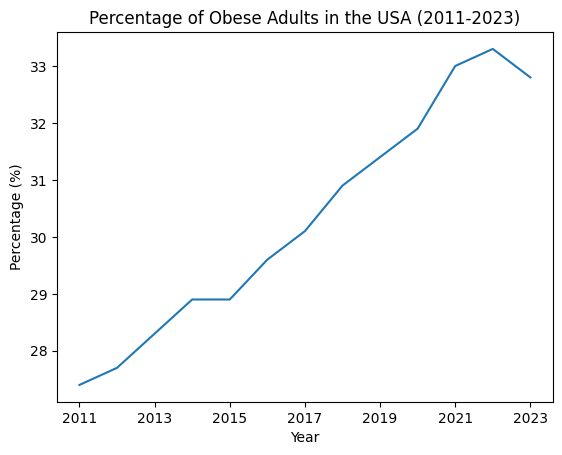

In [88]:
plt.figure(figsize=(6, 4))
table.plot.line(x="Year", y="Percentage of Obese Individuals in the US",
                xlabel="Year", ylabel="Percentage (%)", 
                title = "Percentage of Obese Adults in the USA (2011-2023)", legend=False);

We can see that the national rate of obesity has increased by around 5% from 2011 to 2023, with a slight decrease from 2022 to 2023. 

If we now look at how this rate has evolved between 2011 and 2023 in each US State, we see that 48 States had a positive increase in obesity rates, with Arkansas having the sharpest increase at 9.1%:

In [467]:
# US States' and Territories' Rates of Obesity between 2011 and 2023

r = db.aggregate([
    
    # Here we make sure that "percent" is a double and "year" is an integer:
    {"$addFields": {"percent": {"$toDouble": "$percent"}, "year": {"$toInt": "$year"}}},
    
    # Match for the specific criteria we want with total percentage,
    # years and the question we want
    {"$match": {"population_information.total": "Total", 
                "question": "Percent of adults aged 18 years and older who have obesity",
                "year": {"$in": [2011, 2023]}}},
    
    # Group by state and year and collect the percentages
    {"$group": {"_id": {"state": "$state", "year": "$year"},
                "percentage": {"$first":"$percent"}}},
    
    # Have separate fields for 2011 and 2023 percentages
    {"$group": {"_id": "$_id.state",
                "percent_2011": {"$max": {"$cond": [{"$eq": ["$_id.year", 2011]},
                                                    "$percentage", None]}},
                "percent_2023": {"$max": {"$cond": [{"$eq": ["$_id.year", 2023]},
                                                    "$percentage", None]}}}},

    # Calculate the variation in obesity percentage between 2011 and 2023
    {"$project": {"_id":0, "State":"$_id", "Percentage Variation":
                  {"$subtract": ["$percent_2023", "$percent_2011"]}}},

    # Select only states with an increasing obesity rate and exclude "National"
    {"$match": {"Percentage Variation": {"$gte": 0.0}, "State": {"$ne": "National"}}},
    
    # Sort by state name or variation as needed
    {"$sort": {"Percentage Variation": -1}}
])

df = pd.DataFrame(r)
l = len(df)
print(f"There are {l} US States with increasing rates of obesity")
print("\nThese are the US States with the sharpest increases in obesity:")
df.head(5)

There are 48 US States with increasing rates of obesity

These are the US States with the sharpest increases in obesity:


,State,Percentage Variation
0,Arkansas,9.1
1,New Mexico,9.0
2,Illinois,8.9
3,West Virginia,8.8
4,Iowa,8.8


### 7.5. Which State Has the Lowest Percentage of Adults Consuming Vegetables or Fruits at Least Once per Day?

In this next section, we will look at possible causes of obesity in the Amercian population, starting with nutrition. Improper nutrition is the prime factor contributing to excessive weight gain, so let's see which State has the lowest consumption of healthy food:

In [487]:
 r = db.aggregate([
     # Ensure "percent" is a double for calculations
     {"$addFields": {"percent": {"$toDouble": "$percent"}}},
     
     # Match for only national data for fruit and vegetable consumption questions
     {"$match": {"population_information.total": "Total", 
                "question": {"$in": [
                    "Percent of adults who report consuming fruit less than one time daily", 
                    """Percent of adults who report consuming vegetables
                    less than one time daily""",
                    "Percent of adults aged 18 years and older who have obesity"
                ]}}},
    
    # Group by year and question type to calculate the average percentage for each
     # question per year
    {"$group": {"_id": {"state": "$state", "question": "$question"},
                "average_percent": {"$avg": "$percent"}}},
    
    # Then we use conditional logic to get the average percentage for fruits,
     # for vegetables and for obesity
    {"$group": {
        "_id": "$_id.state",
        "vegetables_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq": ["$_id.question",
                                   """Percent of adults who report consuming vegetables
                                   less than one time daily"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}},
        "fruits_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq": ["$_id.question",
                                   """Percent of adults who report consuming
                                   fruit less than one time daily"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}},
        "obesity_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq": ["$_id.question", """Percent of adults aged 18 years 
                    and older who have obesity"""]},
                    "then": "$average_percent",
                    "else": 0
                }}}}},
    
        # Add averages to get the overall average consumption of healthy
        #food per US State and a separate average for obesity
        {"$project": {"_id":0, "State": "$_id",
        "Percentage of Persons not Eating Healthy Food":
                      {"$add": ["$fruits_avg", "$vegetables_avg"]},
                      "Percentage of Obese Individuals": "$obesity_avg"}},
    
        # Exclude the National percentage.  
        {"$match": {"state":{"$ne":"National"}}},
                
        # Sort the averages by descending order
        {"$sort": {"Percentage of Persons not Eating Healthy Food": -1}}, 

        #limit to 5 results
        {"$limit":5}
 ])
df = pd.DataFrame(r)
df

,State,Percentage of Persons not Eating Healthy Food,Percentage of Obese Individuals
0,Puerto Rico,99.133333,32.018182
1,Guam,72.966667,32.160000
2,Louisiana,72.000000,36.415385
3,Virgin Islands,71.900000,33.075000
4,Mississippi,69.400000,37.615385


It seems that although nutrition is a major factor contributing to an unhealthy weight, we can see here that it is not necessarily correlated to the daily consumption of vegetables or fruit. From the States with the most amount of overweight adults, we only find Louisiana and Mississippi in the above list. Also, even though Mississipi residents eat more fruits and vegetables than Puerto Ricans, their obesity rate is higher than theirs by 4%. 

###  7.6. What Percentage of Americans Regularily Exercise?

We would now like to look into the percentage of Americans who tend to exercise. We can see that there are 5 different options to choose from for exercise. There could be significant overlaps between them and we do not know how the survey was conducted: Was each person asked to choose the most relevant answer or did they select all that applied to them? 

As a consequence, we select "Percent of adults who engage in no leisure-time physical activity" and subtract it from 100 to know the percentage of people engaging in physical activity of some kind.

We are also interested in knowing how physical activity evolves with age along with the percentage of obesity in the population.

In [574]:
# Questions related to physical activity
db.distinct("question", {"topic_of_question":"Physical Activity - Behavior"})

['Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)',
 'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week',
 'Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)',
 'Percent of adults who engage in muscle-strengthening activities on 2 or more days a week',
 'Percent of adults who engage in no leisure-time physical activity']

In [641]:
# These are the age ranges we will consider
db.distinct("population_information.stratification",
            {"population_information.stratification_category":
             "Age (years)"})

['18 - 24', '25 - 34', '35 - 44', '45 - 54', '55 - 64', '65 or older']

In [644]:
# Rates of people exercising

r = db.aggregate([
    
    # Here we make sure that "percent" is a double:
    {"$addFields": {"percent": {"$toDouble": "$percent"}}},  
    
    # We $match only for the questions we are interested in for the population
    # divided by age group with only national percentages
    {"$match": {"population_information.stratification_category": "Age (years)",
                "state":"National",
                "question": {"$in": [
                "Percent of adults aged 18 years and older who have obesity",
                "Percent of adults who engage in no leisure-time physical activity",
                """Percent of adults who achieve at least 150 minutes a week
                of moderate-intensity aerobic physical activity or 75 minutes 
                a week of vigorous-intensity aerobic activity (or an 
                equivalent combination)"""]}}},

    #We calculate the average for each age group: 
    {"$group": {"_id": {"age": "$population_information.stratification",
                        "question":"$question"},
        "average_percent": {"$avg": "$percent"}}},

    # Then we use conditional logic to get the average percentage of each category
    {"$group": {
        "_id": "$_id.age",
        "obesity_avg": {
            "$sum": {
                "$cond": {
                    "if":
                    {"$eq": ["$_id.question",
                                   """Percent of adults aged 18 years
                                   and older who have obesity"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}},
        "vigorous_exercise_avg": {
            "$sum": {
                "$cond": {
                    "if":
                    {"$eq": ["$_id.question",
                                   """Percent of adults who achieve at least 150 minutes 
                                   a week of moderate-intensity aerobic physical activity
                                   or 75 minutes a week of vigorous-intensity aerobic
                                   activity (or an equivalent combination)"""]},
                    "then": "$average_percent",
                    "else": 0  # Exclude values for non-matching question
                }}},
        "exercise_avg": {
            "$sum": {
                "$cond": {
                    "if": {"$eq":
                           ["$_id.question",
                                   """Percent of adults who engage in no leisure-time
                                   physical activity"""]},
                    "then": {"$subtract": [100, "$average_percent"]},
                    #subtract the average from 100 to get the percentage 
                    #of people exercising
                    "else": 0  # Exclude values for non-matching question
                }}}}},
    

     # We choose to show the age ranges, obesity percentages and exercise percentages
    {"$project": {"_id":0, 
                  "Age":"$_id", 
                  "Percentage of Obesity": "$obesity_avg",
                  "Percentage of Individuals Exercising":"$exercise_avg",
                "Percentage of Individuals Vigorously Exercising":
                  "$vigorous_exercise_avg"}},
    
    # Sort the averages by increasing age
    {"$sort": {"Age": 1}}

])
pd.DataFrame(r)

,Age,Percentage of Obesity,Percentage of Individuals Exercising,Percentage of Individuals Vigorously Exercising
0,18 - 24,17.630769,82.892308,54.833333
1,25 - 34,28.707692,79.600000,50.666667
2,35 - 44,33.684615,77.300000,50.933333
3,45 - 54,36.000000,74.630769,51.150000
4,55 - 64,35.215385,72.453846,52.366667
5,65 or older,28.230769,68.361538,54.666667


What we observe is that the percentage of obesity increases with age and reaches a peak at 45 to 54 years of age, but drops off for persons aged 65 or older. Unsurprisingly, the amount of people exercising decreases with age and appears to therefore be negatively correlated to the percentage of obesity nation-wide. 

A majority of individuals maintain some form of exercise, but only around half across all ages do any serious form of exercise which increases heartrate and therefore leads to effectively burning calories.

## 8. Conclusions

In conclusion, we saw that obesity is most prevalent in the South-East of the United States. Certain ethnicities are also more likely to be overweight or obese, with Pacific Islanders on average most likely to fall in these categories. On the other hand, the highest and lowest income  brackets tended to be most likely to have normal BMIs.

Overall, the national percentage of obese adults has been steadily increasing, with a slight decline from 2022 to 2023. Lastly, when considering possible causes of obesity, we observed that the lack of consumption of at least one fruit or vegetable a day was not clearly correlated to excessive weight. On the other hand, as individuals become less active with age, it does appear that they tend to gain weight as well. Furthermore, vigorous or otherwise intensive exercise was not a frequent undertaking by Americans, with only a little over half at all ages practicing some medium to high intensity sport regularily. 

## 9. Learnings
In the context of this project, we learned how to best structure the data that was imported into MongoDB and select which parts of it were truly necessary for our analysis. We also learned how to query the data directly in Python to better understand its structure and to build effective aggregate pipelines to develop an increasingly detailed and thorough analysis.
We found conditional logic within pipelines particularily challenging to implement. They also required some reflexion to understand what specific parts of the data have to be queried. There were some similar fields, such as the ranges in "population_information.age" and the ranges specific to age in "population_information.stratification". It was a bit of a challenge at first to understand that in fact only the latter would work to properly group data by age ranges and return a proper data frame. 

## 10. Disclaimer

Note that Stackoverflow and ChatGPT were used to help formulate the conditional logic for the overweight or obese percentages of population for each US State. Although it was clear that an average had to be calculated over each question per state, then added to each other, it was not quite clear how to formulate the conditional logic in the "$group" part of the pipeline so it was necessary to understand how it should be implemented.

In [89]:
%%HTML
<style>
    /* Hide In/Out column */
    div.prompt { display: none; }
    
</style>